In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

# insert the mymujoco path for TrainDQN.py file
sys.path.insert(0, "/home/luke/mymujoco/rl")

# create modelsaver instance
from ModelSaver import ModelSaver
directory = "pb4_tests_apr23" # ""
saver = ModelSaver(f"test_data/{directory}", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData
data_explorer = GraspTestData()

# enter folder and load test data
test_name = "pb4_EI1_S3_real_objects"
saver.enter_folder(test_name)
try:
  testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
  print(data_explorer.get_test_string(data=testdata, detailed=True))
except TypeError as e:
  print("Loading test data failed, check that the test has actually saved some data")
  print("Error was:", e)

Loading file /home/luke/gripper-ros/test_data/pb4_tests_apr23/pb4_EI1_S3_real_objects/test_data_003.pbz2 with pickle ... finished
Test information

Test name: pb4_EI1_S3_real_objects
Finger width: 0.028
Finger thickness: 0.0009
heuristic test: False
Bending gauge in use: True
Palm sensor in use: True
Wrist Z sensor in use: True
Loaded group name: 07-03-23
Loaded run name: luke-PC_13:37_A10
Loaded best SR: 0.837

Results information:

num_sphere = 60
num_cuboid = 50
num_cylinder = 0
num_cube = 0
sphere_SR = 0.7667
cylinder_SR = 0.0000
cuboid_SR = 0.2600
cube_SR = 0.0000
avg_steps = 126.8364
avg_stable_height = 0.5364
avg_target_height = 0.5364
avg_lifted = 0.5455
avg_exceed_bending = 0.0000
avg_exceed_axial = 0.1636
avg_exceed_limits = 0.0000
avg_loop = 0.0273
avg_dropped = 0.0091
avg_out_of_bounds = 0.0000
avg_exceed_palm = 0.0000

Sphere success rate: 0.7667
cylinder success rate: 0.0000
cuboid success rate: 0.2600
cube success rate: 0.0000

Total number of trials: 110
Total number of

In [42]:
# optionally also print trial information
print_trials = True
_ = data_explorer.get_test_results(data=testdata, print_trials=print_trials)

# print(testdata.trials[-1].steps[-1].SI_state)

Object num = 2, num trials = 10, TH = 0 SH = 0
Object num = 3, num trials = 10, TH = 10 SH = 9
Object num = 4, num trials = 10, TH = 10 SH = 9
Object num = 6, num trials = 10, TH = 6 SH = 4
Object num = 7, num trials = 10, TH = 0 SH = 0
Object num = 11, num trials = 10, TH = 10 SH = 10
Object num = 5, num trials = 10, TH = 10 SH = 4
Object num = 1, num trials = 10, TH = 10 SH = 10
Object num = 8, num trials = 10, TH = 0 SH = 0
Object num = 9, num trials = 10, TH = 0 SH = 0
Object num = 10, num trials = 10, TH = 0 SH = 0
Object num = 12, num trials = 10, TH = 0 SH = 0


In [43]:
save = False

if True:

  # edit test name
  testdata.test_name = "heuristic_EI1_S3_real_objects"

  # edit individual trials to fix errors
  for trial in testdata.trials:

    # if trial.object_num in [0]:
    #   trial.object_num = 7
    #   trial.trial_num = 1
    #   trial.object_name = "sideways tin"

    # if trial.object_num in [1]:
    #   if trial.object_name != "kale bag":
    #     trial.object_name = "kale bag"

    if trial.object_num in [4]:
      print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, name = {trial.object_name}, sh = {trial.stable_height}")
      if trial.trial_num == 6:
        trial.stable_height = 1

    # if trial.object_num == 11:
    #   if trial.object_name == "upright tin":
    #     trial.object_name = "sliced meat"
    #   print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, name = {trial.object_name}")


  # for trial in testdata.trials:
  #   if trial.object_num == 1: trial.object_num = 2
  # for trial in testdata.trials:
  #   if trial.object_num == 0: trial.object_num = 1

  if save: saver.save("test_data", pyobj=testdata)

  # # visualise data from a specific trial
  # for trial in testdata.trials:
  #   if trial.object_num == 6:
  #     step = 11
  #     if trial.trial_num == 6:
  #       print("Trial 1", trial.steps[step - 1])
  #       data_explorer.print_trial(trial, steps=[i for i in range(0, len(trial.steps))])
  #     elif trial.trial_num == 6:  
  #       # data_explorer.print_trial(trial, steps=[i for i in range(15)])
  #       pass

  # # get info about all exceed axial trials
  # exceed_axial_list = []
  # for trial in testdata.trials:
  #   if trial.exceed_axial:
  #     exceed_axial_list.append(trial.steps[-1].SI_state[4])
  # print(f"Number of trials where exceed_axial=True is {len(exceed_axial_list)}")
  # if len(exceed_axial_list) > 0:
  #   print(f"AVERAGE last step wrist Z is: {np.mean(exceed_axial_list):.2f} N")
  #   print(f"MINIMUM last step wrist Z is: {min(exceed_axial_list):.2f} N")
  # pass

Obj. num = 4, trial num = 1, name = lemon, sh = 1
Obj. num = 4, trial num = 2, name = lemon, sh = 1
Obj. num = 4, trial num = 3, name = lemon, sh = 1
Obj. num = 4, trial num = 4, name = lemon, sh = 1
Obj. num = 4, trial num = 5, name = lemon, sh = 0
Obj. num = 4, trial num = 6, name = lemon, sh = 1
Obj. num = 4, trial num = 7, name = lemon, sh = 1
Obj. num = 4, trial num = 8, name = lemon, sh = 1
Obj. num = 4, trial num = 9, name = lemon, sh = 1
Obj. num = 4, trial num = 10, name = lemon, sh = 1
Saving file /home/luke/gripper-ros/test_data/heuristic_EI1_S3_real_objects/test_data_002.pbz2 with pickle ... finished


In [18]:
# # deteremine success rate without certain conditions occuring
# from copy import deepcopy
# testcopy = deepcopy(testdata)
# testcopy.trials = []

# for trial in testdata.trials:
  
#   # when talking about fewer sensor performance without dangerous readings/motors skipping steps:
#   # exclucing loop from S1 is justified as it was very common to see action 2 loops (motors skipping causes loop)
#   # excluding loop from S2 is not justified as most loops were actually raise/lower loops with the palm sensor
#   if not trial.exceed_palm and not trial.exceed_axial and not trial.loop:
#     testcopy.trials.append(deepcopy(trial))

# print(data_explorer.get_test_string(data=testcopy, detailed=True))

Test information

Test name: pb4_EI1_S2
Finger width: 0.028
Finger thickness: 0.0009
heuristic test: False
Bending gauge in use: True
Palm sensor in use: True
Wrist Z sensor in use: False
Loaded group name: 13-03-23
Loaded run name: luke-PC_17:23_A122
Loaded best SR: 0.720

Results information:

num_sphere = 16
num_cuboid = 19
num_cylinder = 38
num_cube = 7
sphere_SR = 0.6875
cylinder_SR = 0.8947
cuboid_SR = 0.9474
cube_SR = 0.8571
avg_steps = 118.2500
avg_stable_height = 0.8625
avg_target_height = 0.9375
avg_lifted = 1.0000
avg_exceed_bending = 0.0000
avg_exceed_axial = 0.0000
avg_exceed_limits = 0.0000
avg_loop = 0.0000
avg_dropped = 0.0375
avg_out_of_bounds = 0.0000
avg_exceed_palm = 0.0000

Sphere success rate: 0.6875
cylinder success rate: 0.8947
cuboid success rate: 0.9474
cube success rate: 0.8571

Total number of trials: 80
Total number of objects: 28
Overall success rate: 0.8625



Loading file /home/luke/gripper-ros/test_data/pb4_tests_apr23/pb4_EI1_S3_real_objects/trial_image_batch_060.pbz2 with pickle ... finished
There are 117 images


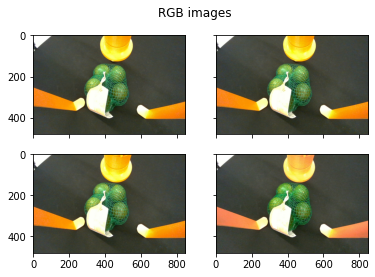

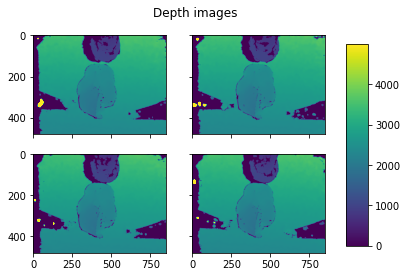

In [15]:
# prepare to load image data
new_test = False
if new_test:
  test_name = "pb4_EI1_S3"
  saver.enter_folder(test_name)

# extract the image data
imagedata = saver.load(id=60, filenamestarts="trial_image_batch")
image_list = imagedata.trials[0].images
print("There are", len(image_list), "images")

# how many images would we like to plot
rows = 2
cols = 2

num_images = rows * cols
if num_images > len(image_list): num_images = len(image_list)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(rows, cols, sharex=True, sharey=True)

# saturate any values above this (ignore outliers)
depth_max = 5000

# find minimum of minima & maximum of depth data
dmin = 1e10
dmax = -1e10
for i in range(len(image_list)):
  this_min = np.min(image_list[i].depth[image_list[i].depth < depth_max])
  this_max = np.max(image_list[i].depth[image_list[i].depth < depth_max])
  if this_min < dmin: dmin = this_min
  if this_max > dmax: dmax = this_max

for j in range(num_images):
  ix = j // cols
  iy = j % cols
  axs[ix][iy].imshow(image_list[j].rgb, aspect="auto")
  im2 = axs2[ix][iy].imshow(image_list[j].depth, vmin=dmin, vmax=dmax, aspect='auto', cmap="viridis")

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
fig2.colorbar(im2, cax=cbar_ax)

fig.suptitle("RGB images")
fig2.suptitle("Depth images")

fig.set_size_inches((cols * 3, rows * 2))
fig2.set_size_inches((cols * 3, rows * 2))

plt.savefig("/home/luke/gripper-ros/test_data/demo_depth_data.png")
plt.show()
